# Linear Regression - Implementation and Exploration

## Concepts:

###**Definition of Linear Model**:
A linear model is defined as following:

$$
f(X) = b + w_1x_1 + w_2x_2... w_nx_n \tag{1}
$$

where capital case X is eqal to a set of features $X = \{x_0, x_1, x_3 ... x_n\}$, and weights $W = \{w_1, w_2, w_3 ... w_n\}$ are the parameters we wish to modify in the model. For simplicity bias "$b$" is often incooprated inside the weight and is written in its matrix form:

$$
Y = X_{\text{(n,m)}}W_{\text{(m,1)}} \tag{2}
$$

The subscripts are matrix dimensions where $n$ is the number of sample and $m$ is the number of features


###**Objective**:
Note that a linear model predicts quantitative variables. If you want to perform classification (prediction of categorical variables), then this is not the correct model.

To improve the prediction all we want to do is to minimize the difference between prediction and truth:

$$
Difference = y_{\text{pred}} - y_{\text{true}}
$$

In order to minimize the difference, we need to find a formula that we can operate with. Based on the 2D statistic for linear regression we know that minimizing sum of squared error (SSE) can help us figure out the line of best fit:

$$
\text{SSE} = \sum_{i=1}^{n} \left( y_{\text{pred},i} - y_{\text{true},i} \right)^2
\tag{3}
$$

Alternatively we can write the mean squared error (MSE) like this:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_{\text{pred},i} - y_{\text{true},i} \right)^2
$$

Where n is the sample size.

###**Minimizing the Loss (Analytical Solution)**:
To find the line of best fit in N-dimension we are just essentially applying the 2D regression to more dimensions. Hence all we want to do is to minimize the Squared error. Most people choose to use MSE, so we will do it this way. We can rewrite the formula:

$$
\text{MSE} = \frac{1}{n} \sum (Y - XW)^2
$$

If we leave it as matrix of erros, we can have:

$$
Error = (Y - XW)^T(Y - XW) = Y^TY - Y^T(XW) - (XW)^TY + (XW)^TXW
$$

Where $Y$ is the truth for feature $X$, and $W$ is the parameters.


To find the minimum all we need to do is to take derivative with respect to W:

$$
\frac{d}{dW} Error = 0 = \frac{d}{dW} [Y^TY - Y^T(XW) - (XW)^TY + (XW)^TXW]
$$

Since we know for scalar $r = r^T$, we can merge $Y_{\text{(n,1)}}^T(X_{\text{(n,m)}}W_{\text{(m,1)}}) and (X_{\text{(n,m)}}W_{\text{(m,1)}})^TY_{\text{(n,1)}}$ to get:

$$
0 = Y^TY - 2 W^TX^TY + W^TX^TXW
$$

Now we take the derivative with respect to W

$$
0 = \frac{d}{dW} (Y^TY - 2 W^TX^TY + W^TX^TXW) = 0 - 2X^TY + 2X^TXW
$$

$$
0 = - 2X^TY + 2X^TXW
$$

$$
X^TY = X^TXW
$$
Here we assume $X^TX$ exist and is a full column rank, which means it is positive, definite and invertible:
$$
W = (X^TX)^{\text{-1}}X^TY \tag{4}
$$

$(X^TX)^{\text{-1}}X^TY$ is known as the closed form (analytical) solution for linear regression. Because linear regression is simplier this is also the global minimum we will have.

###**Minimize Loss Function (Gradient Descent)**:
While closed form solution offers a great way to derive global minimum it comes with many downsides:
1. Infeasibility with large datasets
2. When X is not invertible or when we work with a fat data (features > sample size)

An alternative way that has been recently shown to be even better is to solve by mini-batch stochastic gradient descent which splits the data into small chunck and improve the model a tiny bit every time.

This method is particulary effective when we have complicated models with multiple global and local minimum. It also prevents saddle points (where the slope is 0, but not minimum) due to its noise.

In multi-variable calculus, a gradient is defined as follow:

$$
∇f(x, y, z) = \{ \frac{∂}{∂x}f(x,y,z), \frac{∂}{∂y}f(x,y,z), \frac{∂}{∂z}f(x,y,z) \}
$$

So the Gradient of the Loss:

$$
∇loss_w = \frac{2}{n} \left( Y_{\text{true}} - XW \right) X
\tag{5}
$$

We can then apply this loss to get the new weight in a recursive manner:

$$
W_{new} = W_old - a * ∇loss \tag{6}
$$


## Install Dependencies

In [ ]:
! pip install datasets

In [ ]:
from datasets import load_dataset, get_dataset_split_names
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub

## Step 1. Data Preprocessing & Exploration

**Introduction**:

There are many datasets out there to try, but in this code, we will explore gym-member exercise dataset from kaggle.

This dataset includes: Age, Gender, Blood Pressure, BMI, Calories, and more.

What we will be doing here is to predict the number of calories used based on their session.

**Key points to be aware in preprocessing**:
1. **NULL / NA Values**:
  - **Direct Removal**: remove rows without value. Feasible with small number of *NA* and a large dataset. But if there are many *NAs* in an important feature we might need to reconsider.
  - **Fill in with Hypothetical values**: use algorithms to replace NA value in an unbiased way, but must use with caution.
2. **Feature Selection**:
  - **With Domain Knowledge**: you can select what every you think is the best for the model given you think you have enough domain knowledge (can out perform algorithm).
  - **Without Domain Knowledge**: use algorithms to select or remove features instead.
3. **Outliers**: in some models, noise produce from outliers can make the model more robust, but in other models it can impact performance.
4. **Categorical Data**: one hot encoding to convert categorical to numerical data.
5. **Normality Check**: while not all require, some model relies on distance metric for performance. The main advantages includes: *stability in optimization*, *faster convergence*, and *issues related to vanishing/exploding training parameters*.
  - **Transformation**: log transform and square root transform are the most common ones.
6. **Dimensionality Reduction**: usually associated with performance. The higher the dimensionality the longer the training duration.

Key points specific to classification problems:
1. **Imbalanced Data**: in some case we have minority class (small sample size) and majority class (large sample size). This will skew the model towards majority class which may not be desired. Hence, might need to over/under sample.

In [ ]:
# Download Dataset
path = kagglehub.dataset_download("valakhorasani/gym-members-exercise-dataset")
dataset_gym = load_dataset(path)
df_gym = pd.DataFrame(dataset_gym['train'])

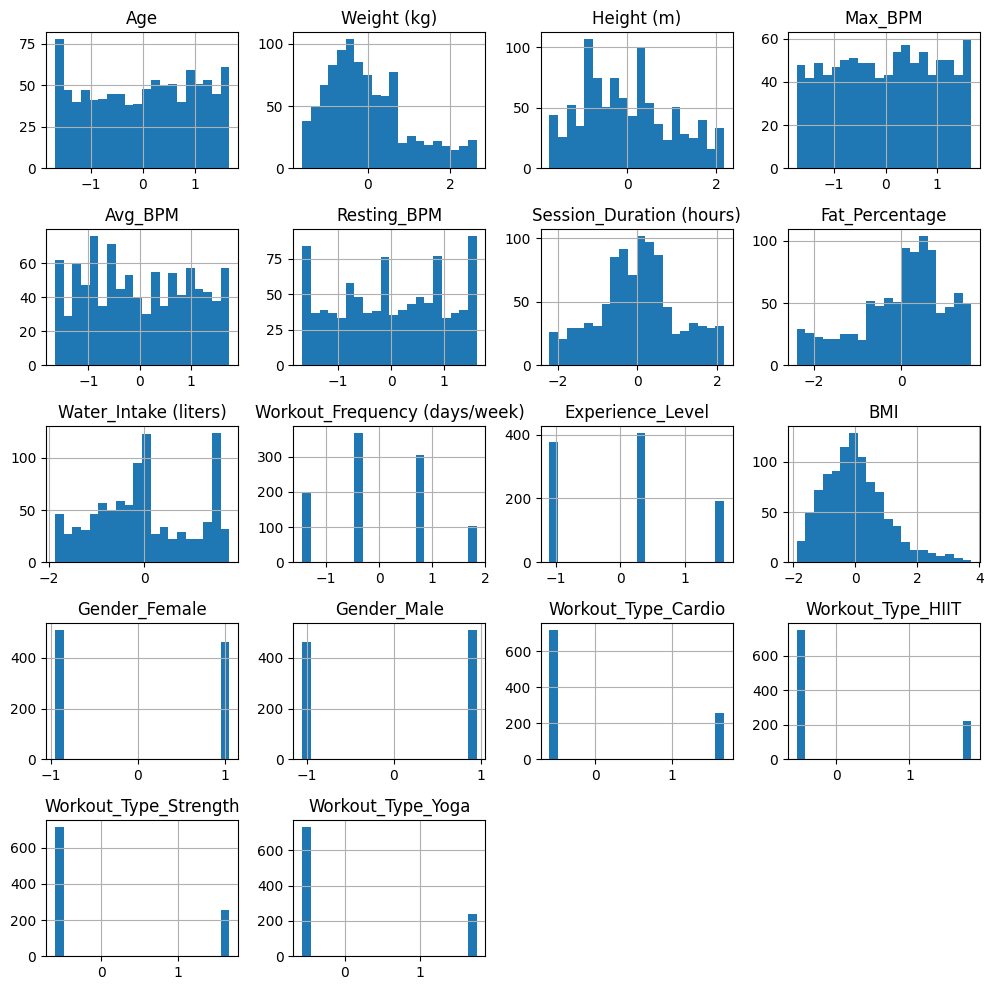

In [ ]:
# Split features and target based on interest
df_features, df_target = Feature_Target_Split(df_gym, "Calories_Burned")

# One-hot encode all categorical variables
df_features = one_hot_encode(df_features)
# Transform data to gaussian distribution
df_features = normalize(df_features)

# Plot the result
df_features.hist(figsize=(10, 10), bins=20)
plt.tight_layout()
plt.show()

In [ ]:
# Some other useful commands
# - df: referse to pandas dataframe

# To View datatype:
#df.dtypes

# To view NAs in each column:
#print(df.isna().sum())

# To visualize the distribution of features:
#df.hist(figsize=(10, 10), bins=20)
#plt.tight_layout()
#plt.show()

# One-hot encoding (2nd line is optional: converse bool to int):
#df = pd.get_dummies(df)
#df = df_encoded.astype(int)

# Normalize dataset using gaussian distribution (note: StandardScaler converts result into numpy array)
#scaler = StandardScaler()
#df_scaled = scaler.fit_transform(df)
#df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Pairwise Plot (Scatter plot of relationships between features)
# sns.pairplot(df)

In [ ]:
################ COMMON FUNCTIONS USED IN PREPROCESSING ########################
# Function that splits features and prediction target (Dataframe)
def Feature_Target_Split(df, target_name, normalize = True):
    Y = df[f"{target_name}"]
    X = df.drop(columns = [f"{target_name}"])
    return X, Y

# Function that one-hot encode the dataset (Dataframe)
def one_hot_encode(df, features=None):
    if features:
        for feature in features:
            # One-hot encode the feature (set to float)
            df_encoded = pd.get_dummies(df[feature], prefix=feature).astype(float)
            # Drop the original feature and concatenate the encoded columns
            df = pd.concat([df, df_encoded], axis=1).drop(columns=[feature])
        return df
    else:
        return pd.get_dummies(df).astype(float)

# Function that normalize features (Dataframe)
def normalize(df):
    scaler = StandardScaler()
    df_normalized = scaler.fit_transform(df)
    return pd.DataFrame(df_normalized, columns=df.columns)

# Step 2. Define Linear Regression

In [232]:
class LinearRegression:
    def __init__(self, add_bias = True):
        self.add_bias = add_bias
        self.weights = []

    # Linear regression gradient: gradient = (1/N) * X * (Y - XW)
    def gradient_function(self, X, Y, regularization = None):
        pred = np.dot(X, self.weights)
        diff = pred - Y                                   # Important Pitfall: It is always Pred - Y, not Y - Pred
        gradient = np.dot(X.T, diff) / X.shape[0]

        if regularization is not None:
            if regularization == "L1":        # L1 Regularization (Lasso)
                gradient += np.sign(self.weights)
            elif regularization == "L2":      # L2 Regularization (Ridge)
                gradient += self.weights
        return gradient

    # Fit function to update weights (everytime fit is called, old weights are scratched)
    def fit(self, X, Y, optimizer = None):
        # When only one feature provided
        if X.ndim == 1:
            X = X[:,None]

        # If adding bias (append ones to last column)
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        # If optimizer is provided (a gradient descent class)
        if optimizer:
            self.weights = np.ones((X.shape[1], 1))
            optimizer.optimize(self, X, Y)
        # If not provided, use analytical solution instead: W* = (X.T * X)^(-1) * X.T * Y
        else:
            # Note: both "np.dot()" and "@" means matrix multiplication
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ Y

    # Make predictions based on weights we have
    def predict(self, X):
        # If weights are not initialized
        if self.weights is None:
            print("Weights are not initialized. Please train the model first!")
            return

        # When only one feature provided
        if X.ndim == 1:
            X = X[:,None]

        # If adding bias (append ones to last column)
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        return X @ self.weights

    # Calculate the loss
    def loss(self, X, Y):
      pred = self.predict(X)
      mse = np.mean(np.square(pred - Y))

      mean_y = np.mean(Y)
      normalized_mse = mse / mean_y
      return normalized_mse

In [237]:
class Gradient_Descent:
    def __init__(self, learning_rate = 0.01, batch_size = 32, epochs = 10, max_iters = 1e6, epsilon = 1e-5, verbose = True, regluarization = None):
        self.learning_rate = learning_rate        # Weight tuning magnitude per iteration
        self.batch_size = batch_size              # Size of data per iteration
        self.epochs = epochs                      # Number of times we will go through the data
        self.max_iters = max_iters                # Max iterations (early stopping)
        self.epsilon = epsilon                    # Stop when gradient is too small
        self.regularization = regluarization      # Apply penalty to large weights

        self.verbose = verbose

    def optimize(self, model, X, Y):
        t = 0
        n = X.shape[0]
        for i in range(self.epochs):
            # Split the dataset into batches
            X_batches = np.array_split(X, np.ceil(n / self.batch_size))
            Y_batches = np.array_split(Y, np.ceil(n / self.batch_size))

            # Loop through each batches
            for X_batch, Y_batch in zip(X_batches, Y_batches):
                # Perform gradient descent
                gradient = model.gradient_function(X_batch, Y_batch, self.regularization)
                model.weights -= self.learning_rate * gradient

                # EARLY STOPPING: stop if max iteration is reached
                if t >= self.max_iters:
                    return
                # EARLY STOPPING: stop if gradient is smaller then threshold
                if np.linalg.norm(gradient) <= self.epsilon:
                    return

                # keep track of iterations:
                t += 1

            # If verbose
            if self.verbose:
                # Because bias is already added, we should remove it first (the prediction function will add it back)
                if model.add_bias:
                  X_batch = X_batch[:, :-1]
                # Calculate the loss without the bias column
                MSE = model.loss(X_batch, Y_batch)
                print(f"Epoch:{i+1}/{self.epochs} - Loss: {MSE}")

# Step 3. Close Form Solution

In [ ]:
# Convert preprocessed data to numpy array
X = np.array(df_features)
Y = np.array(df_target)[:,None]

# Split the data to test and train
X_train, Y_train, X_test, Y_test = Train_Test_Split(X, Y)

# Verify the result is accurate
print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")

X train shape: (778, 18)
Y train shape: (778, 1)
X test shape: (195, 18)
Y test shape: (195, 1)


In [ ]:
# Analytical Solution (Using all features to predict calories)
model = LinearRegression()                      # Create the Linear Regression Model
model.fit(X_train, Y_train)                     # Fit the model (train the weights)
predictions = model.predict(X_test)             # Make prediction after training
loss = MSE(predictions, Y_test)                 # Calculate the loss (unormalized)
loss_n = normalized_MSE(predictions, Y_test)    # Calculate the loss (normalized)
print(f"The final loss (unormalized): {loss}")
print(f"The final loss (normalized): {loss_n}")

# Output:
# The final loss (unormalized): 2823.980883111364 --> Which seems abnormal at first
# but it turns out to be quick reasonable because:
# 1. We did not normalize the target, so it will be lose in terms of the unit (so calories)
# 2. When we graph the prediction vs ground truth the mode follows the linear regression with some noise

# To standardize the loss so it is comparable for different data, we can normalized the loss
# The final loss (normalized): 3.1302475100000344 --> this result now should be comparable in all tests

The final loss (unormalized): 2823.980883111364
The final loss (normalized): 3.1302475100000344


In [247]:
# Visualize Difference Between Prediction and Truth (In Table)
df_comparison = pd.DataFrame({
    'Predictions': predictions.flatten(),
    'Ground Truth': Y_test.flatten()
})
print(df_comparison)

     Predictions  Ground Truth
0     531.625251         463.0
1     835.177673         836.0
2     817.358192         886.0
3    1028.786481        1003.0
4     714.809267         699.0
..           ...           ...
190   561.328314         424.0
191   965.473609         952.0
192   918.772575         911.0
193   911.577342         914.0
194   792.472930         805.0

[195 rows x 2 columns]


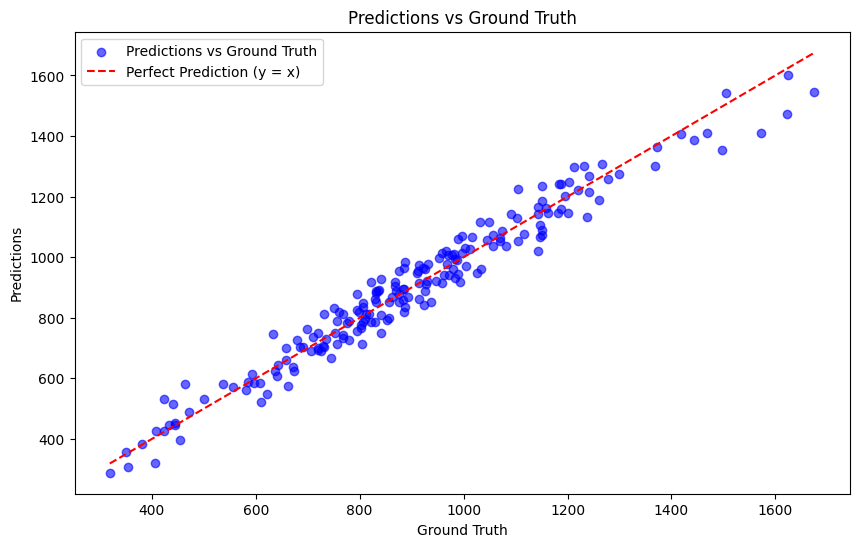

In [ ]:
# Visualize Prediction and Truth
plt.figure(figsize=(10, 6))

# Scatter plot to compare predictions and ground truth
plt.scatter(df_comparison['Ground Truth'], df_comparison['Predictions'], label="Predictions vs Ground Truth", color='blue', alpha=0.6)

# Plot the identity line (y = x) to visualize perfect predictions
plt.plot([min(df_comparison['Ground Truth']), max(df_comparison['Ground Truth'])],
         [min(df_comparison['Ground Truth']), max(df_comparison['Ground Truth'])],
         color='red', linestyle='--', label="Perfect Prediction (y = x)")

plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth (Predictor: Calories)')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Get the loss based on prediction and ground truth (Numpy Array)
def MSE(y_pred, y_truth):
    return np.mean(np.square(y_pred - y_truth))

# Alternative result that normalizes loss
def normalized_MSE(y_pred, y_truth):
    # Calculate the MSE (Mean Squared Error)
    mse = np.mean(np.square(y_pred - y_truth))

    # Normalize by the mean of the ground truth values
    mean_y = np.mean(y_truth)
    normalized_mse = mse / mean_y

    return normalized_mse

# Function that splits data into test and train sets (Numpy Array)
def Train_Test_Split(X, Y, split = 0.8, seed = 42):
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Shuffle indices
    indices = np.random.permutation(len(X))

    # Define the split size (80% train, 20% test)
    train_size = int(0.8 * len(X))

    # Split indices for train and test sets
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    # Split X and Y based on shuffled indices
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]

    return X_train, Y_train, X_test, Y_test

# Step 4. Mini-Batch Stochastic Gradient Descent

In [238]:
# Convert preprocessed data to numpy array
X = np.array(df_features)
Y = np.array(df_target)[:,None]

# Split the data to test and train
X_train, Y_train, X_test, Y_test = Train_Test_Split(X, Y)

# Verify the result is accurate
print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")


X train shape: (778, 18)
Y train shape: (778, 1)
X test shape: (195, 18)
Y test shape: (195, 1)


In [ ]:
# Function that splits data into folds (Numpy Array)
def Cross_Validation_Split(X, Y, current_split, k_fold):
    # Calculate the chunk size (split size)
    chunk_size = len(X) // k_fold

    # Define the start and end indices for the validation set
    start_index = current_split * chunk_size
    end_index = (current_split + 1) * chunk_size if current_split < k_fold - 1 else len(X)

    # Define validation data for the current fold
    x_val, y_val = X[start_index:end_index], Y[start_index:end_index]

    # Define training data by excluding the current fold
    x_train = np.concatenate([X[:start_index], X[end_index:]])
    y_train = np.concatenate([Y[:start_index], Y[end_index:]])

    return x_train, y_train, x_val, y_val

In [266]:
# A function that runs the Entire Training Process
def Run_Linear_Regression(X_train, Y_train, X_test, Y_test, add_bias = True, k_fold = 5, learning_rate = 0.01, batch_size = 32, epochs = 10, max_iters = 1e6, epsilon = 1e-5, verbose = True, regluarization = None):
    optimizer = Gradient_Descent(learning_rate, batch_size, epochs, max_iters, epsilon, verbose, regluarization)
    model = LinearRegression(add_bias)

    # Perform Cross Validation on Train Set
    for i in range(k_fold):
        x_train, y_train, x_val, y_val = Cross_Validation_Split(X_train, Y_train, i, k_fold)
        model.fit(x_train, y_train, optimizer)
        predictions = model.predict(x_val)
        loss_n = normalized_MSE(predictions, y_val)
        if verbose:
            print(f"Cross Validation {i+1}/{k_fold} Loss: {loss_n}")

    predictions = model.predict(X_test)
    loss_n = normalized_MSE(predictions, Y_test)
    if verbose:
        print(f"Final Loss: {loss_n}")
    return predictions, loss_n

In [249]:
def visualize_predictions_vs_truth(predictions, y):
    # Create a DataFrame to compare Predictions and Ground Truth
    df_comparison = pd.DataFrame({
        'Predictions': predictions.flatten(),
        'Ground Truth': y.flatten()
    })

    # Print the comparison table
    print(df_comparison)

    # Create a figure for the plot
    plt.figure(figsize=(10, 6))

    # Scatter plot to compare predictions and ground truth
    plt.scatter(df_comparison['Ground Truth'], df_comparison['Predictions'],
                label="Predictions vs Ground Truth", color='blue', alpha=0.6)

    # Plot the identity line (y = x) to visualize perfect predictions
    plt.plot([min(df_comparison['Ground Truth']), max(df_comparison['Ground Truth'])],
             [min(df_comparison['Ground Truth']), max(df_comparison['Ground Truth'])],
             color='red', linestyle='--', label="Perfect Prediction (y = x)")

    # Adding labels and title
    plt.xlabel('Ground Truth')
    plt.ylabel('Predictions')
    plt.title('Predictions vs Ground Truth (Predictor: Calories)')

    # Displaying the legend
    plt.legend()

    # Show the plot
    plt.show()


In [255]:
prediction = Run_Linear_Regression(X_train, Y_train, X_test, Y_test, verbose = False)

Final Loss: 26.87393386844222


     Predictions  Ground Truth
0     496.443150         463.0
1     694.143871         836.0
2     624.646715         886.0
3     862.835442        1003.0
4     520.466982         699.0
..           ...           ...
190   554.473322         424.0
191   707.450922         952.0
192   736.446198         911.0
193   717.250274         914.0
194   650.988506         805.0

[195 rows x 2 columns]


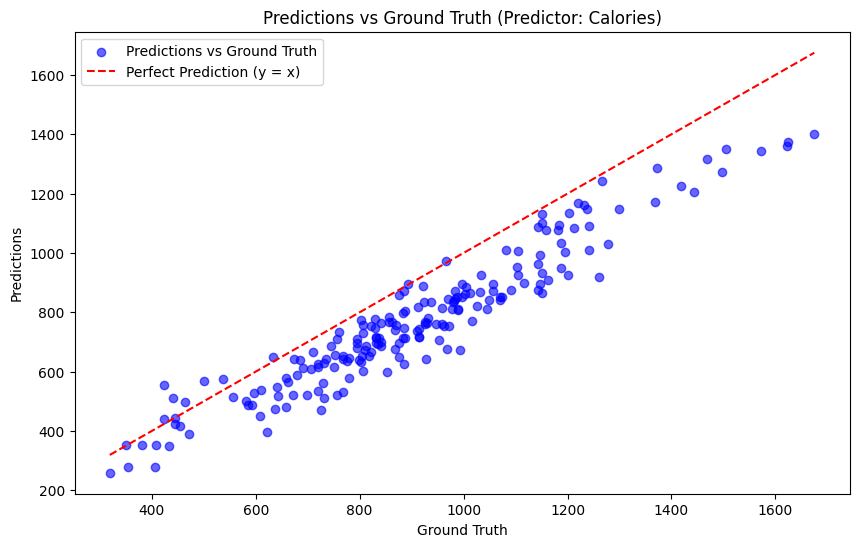

In [256]:
visualize_predictions_vs_truth(prediction, Y_test)

# Step 5. Tunning Parameters

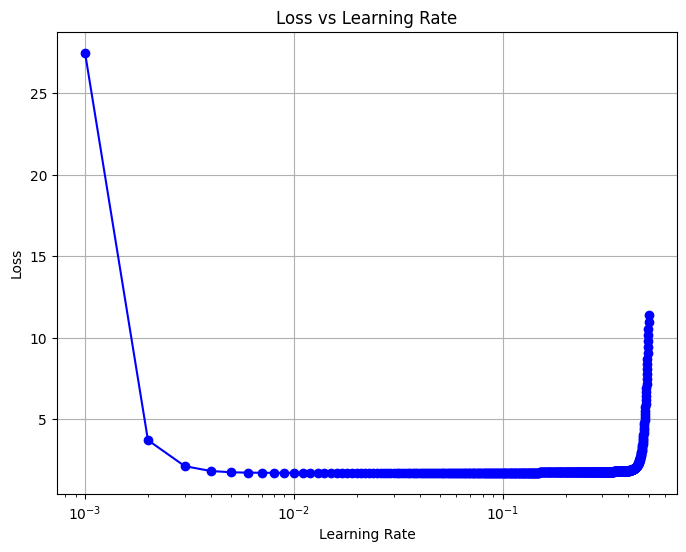

In [267]:
# List of learning rates
learning_rates = np.arange(0.001, 0.501, 0.001)

# Initialize an empty list to store losses
losses = []

# Loop over learning rates
for alpha in learning_rates:
    prediction, loss = Run_Linear_Regression(X_train, Y_train, X_test, Y_test, learning_rate=alpha, epochs = 100, verbose=False)
    losses.append(loss)  # Corrected to use append() method

# Plot the loss for each learning rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, losses, marker='o', linestyle='-', color='b')
plt.title('Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')  # You can use log scale to make the differences clearer if the range is wide
plt.grid(True)
plt.show()

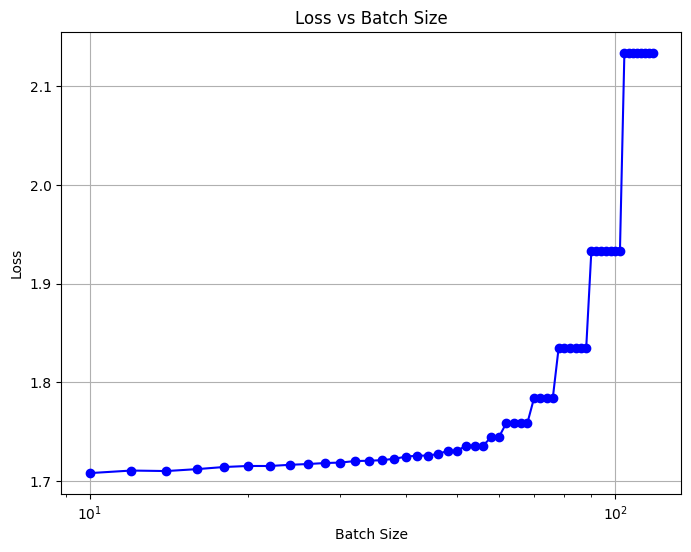

In [270]:
# List of batch size
batch_sizes = np.arange(10, 120, 2)

# Initialize an empty list to store losses
losses = []

# Loop over learning rates
for size in batch_sizes:
    prediction, loss = Run_Linear_Regression(X_train, Y_train, X_test, Y_test, batch_size=size, epochs = 100, verbose=False)
    losses.append(loss)  # Corrected to use append() method

# Plot the loss for each learning rate
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes, losses, marker='o', linestyle='-', color='b')
plt.title('Loss vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.xscale('log')  # You can use log scale to make the differences clearer if the range is wide
plt.grid(True)
plt.show()